## Importing Libraries

This section includes essential libraries for data handling and analysis:

- **NumPy & Pandas**: For numerical computations and data manipulation.
- **os & tempfile**: To handle file operations.
- **Matplotlib & PIL**: For data visualization and image processing.
- **cv2 (OpenCV)**: For advanced image processing tasks.
- **sklearn**: Includes tools for machine learning tasks, such as model building and evaluation with `DecisionTreeClassifier`, `accuracy_score`, and `classification_report`.
- **warnings & random**: To manage warnings and generate random data.
- **joblib**: To save and load models.
-

A confirmation message ensures all libraries are loaded correctly.


In [41]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import random
import cv2
import tempfile
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import joblib

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Setting Up Data Directory Structure

This code block is responsible for setting up and verifying the directory structure for training, testing, and validation datasets. Here's a breakdown of the operations:

- **base_dir**: Specifies the base directory where the data is expected to be stored.
- **sub_dirs**: A dictionary that outlines the main directories (`train`, `test`, `val`) and their respective subdirectories (`NORMAL`, `PNEUMONIA`).
- **dir_paths**: A dictionary to store the paths of the main and subdirectories.
- **temp_dir_base**: Creates a temporary directory which can be used for temporary data handling.

The script checks if each main and subdirectory exists. If a directory is missing, it raises a `FileNotFoundError` with a detailed error message, helping in troubleshooting missing data issues.

Upon successful verification, a confirmation message "✅ Data directories are successfully loaded" is printed, indicating all necessary directories are in place and correctly structured.

In [9]:
base_dir = './data'
sub_dirs = {
    'train': ['NORMAL', 'PNEUMONIA'],
    'test': ['NORMAL', 'PNEUMONIA'],
    'val': ['NORMAL', 'PNEUMONIA']
}

dir_paths = {}
temp_dir_base = tempfile.mkdtemp()
# if true then create a ./local/data here and set that to temp_dir_base
shoud_use_local_data = True
if shoud_use_local_data:
    temp_dir_base = os.path.join(os.getcwd(), 'data/local')
    if not os.path.exists(temp_dir_base):
        os.makedirs(temp_dir_base)
    print('🟢 Using local data'
          f'📂 {temp_dir_base}')
else :
    temp_dir_base =  tempfile.mkdtemp()
    print('🟢 Using temporary data'
          f'📂 {temp_dir_base}')
    

    

for dir_key, subfolders in sub_dirs.items():
    main_dir_path = os.path.join(base_dir, dir_key)
    if not os.path.exists(main_dir_path):
        raise FileNotFoundError(f'👺 {dir_key.capitalize()} directory does not exist')
    
    dir_paths[dir_key] = main_dir_path  

    for subfolder in subfolders:
        subfolder_path = os.path.join(main_dir_path, subfolder)
        if not os.path.exists(subfolder_path):
            raise FileNotFoundError(f'👺 {dir_key.capitalize()} {subfolder.lower()}  directory does not exist')
        
        dir_paths[f"{dir_key}_{subfolder.lower()}"] = subfolder_path
print('✅ Data directories are successfully loaded')

🟢 Using local data📂 c:\Users\i\Documents\project\t-dev-810-par_14\data/local
✅ Data directories are successfully loaded


Number of samples in training directory for NORMAL is 1341
Number of samples in training directory for PNEUMONIA is 3875
Number of samples in testing directory for NORMAL is 234
Number of samples in testing directory for PNEUMONIA is 390
Number of samples in validation directory for NORMAL is 8
Number of samples in validation directory for PNEUMONIA is 8


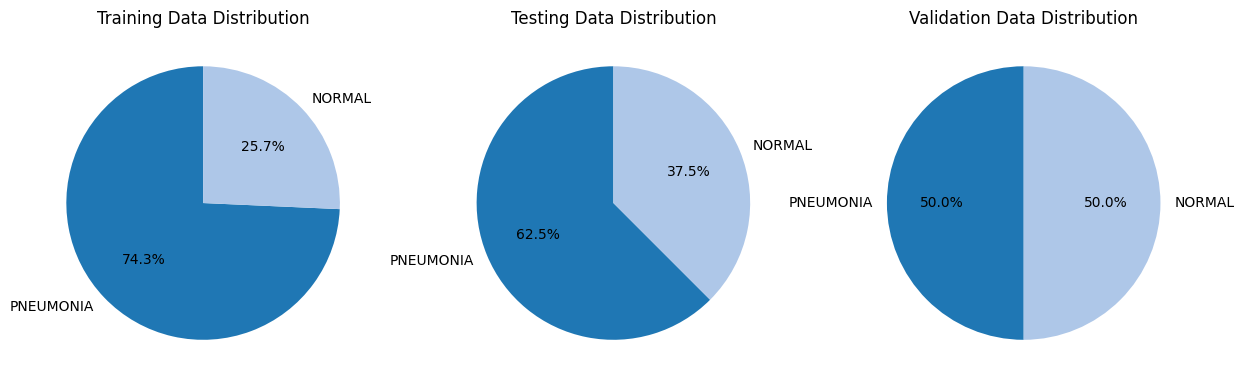

In [10]:
# TO SEE THE NUMBER OF SAMPLES IN EACH DIRECTORY
def sample_count(direct, dirname):
    sub_dir = os.listdir(direct)
    counts = {}
    for direc in sub_dir:
        classpath = os.path.join(direct, direc)
        filelist = os.listdir(classpath)
        counts[direc] = len(filelist)
        print(f"Number of samples in {dirname} directory for {direc} is {len(filelist)}")
    return counts

# Collect data
train_counts = sample_count(dir_paths['train'], "training")
test_counts = sample_count(dir_paths['test'], "testing")
val_counts = sample_count(dir_paths['val'], "validation")

# Data preparation for plotting
categories = set(train_counts.keys()).union(test_counts.keys(), val_counts.keys())
data = {'Training': [], 'Testing': [], 'Validation': []}
for category in categories:
    data['Training'].append(train_counts.get(category, 0))
    data['Testing'].append(test_counts.get(category, 0))
    data['Validation'].append(val_counts.get(category, 0))

# Plot pie chart for data distribution in each directory all 3 in one line 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (key, value) in enumerate(data.items()):
    ax[i].pie(value, labels=categories, autopct='%1.1f%%', startangle=90, colors= plt.cm.tab20.colors)
    ax[i].set_title(f'{key} Data Distribution')
plt.show()


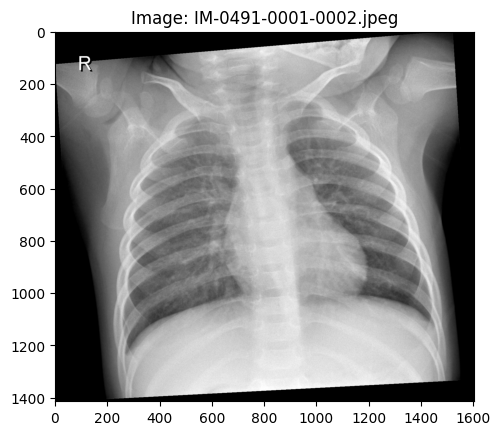

Shape of image from ./data\train\NORMAL\IM-0491-0001-0002.jpeg is (1414, 1604, 3)


In [11]:
# TO SEE A RANDOM IMAGE FROM THE DATASET
def plot_image(image_path, title=""):
    """
    Display an image using matplotlib and print its details.
    
    Parameters:
    image_path (str): The directory where the image is stored.
    title (str): The filename of the image to display.
    """
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    plt.title(f"Image: {title}")
    plt.show()
    print(f"Shape of image from {image_path} is {img.shape}")

random_dir = random.choice(['train_normal', 'train_pneumonia', 'test_normal', 'test_pneumonia'])
filelist = os.listdir(dir_paths[random_dir])
filelist_random = random.choice(filelist)
plotted_image = os.path.join(dir_paths[random_dir], filelist_random)
plot_image(plotted_image, filelist_random)

## Image File Validation and Dimension Analysis

### Function: `is_image_file`
This function checks if a file is an image based on its extension. It returns `True` for files ending in `.png`, `.jpg`, or `.jpeg`, ensuring files like `.DS_Store` are ignored.

### Function: `avg_height_width`
Calculates the average height, width, and aspect ratio of images within a specified directory:
- **File Filtering**: Only processes files identified as images by `is_image_file`.
- **Error Handling**: Generates an error if no image files are found or if an image cannot be read.
- **Dimension Calculation**: Computes the average dimensions and aspect ratio of all images in the directory, outputting the results.

### Aggregated Statistics
The script aggregates these measurements across different dataset splits (train, test, val) for 'NORMAL' and 'PNEUMONIA' categories, then calculates the overall average dimensions and aspect ratio for the entire dataset. This helps in understanding the uniformity and scaling needs of the images across the dataset.

Outputs include individual and total average heights, widths, and aspect ratios, providing a comprehensive overview of the dataset's image properties.


In [13]:
def is_image_file(filename):
    # Pour eviter les fichiers cachés .DS_Store par exemple
    return filename.lower().endswith(('.png', '.jpg', '.jpeg'))

#hist2d to show the distribution of the images in the dataset
hist_data = {
    'x': [],
    'y': [],
}

def avg_height_width(path):
    filelist = [file for file in os.listdir(path) if is_image_file(file)]
    ht, wt = 0, 0
    count_images = len(filelist)
    
    if count_images == 0:
        raise ValueError(f"No image files found in the directory {path}.")
    print("Calculating average height and width of images in ", path)
    
    for x in filelist:
        img_path = os.path.join(path, x)
        try:
            img = plt.imread(img_path)
            shape = img.shape
            
            hist_data['x'].append(shape[0])
            hist_data['y'].append(shape[1])
                
            ht += shape[0]
            wt += shape[1]
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue

    if ht == 0 or wt == 0:  
        raise ValueError(f"Calculated zero height or width for images in {path}.")
    
    average_height = ht / count_images
    average_width = wt / count_images
    aspect_ratio = ht / wt
    print(f"Average height and width of images in {path} are {average_height} and {average_width} respectively, with aspect ratio {aspect_ratio}")
    return {'height': average_height, 'width': average_width, 'aspect ratio': aspect_ratio}


average_height_width_train = {
    "train":{
        'normal': avg_height_width(dir_paths['train_normal']),
        'pneumonia': avg_height_width(dir_paths['train_pneumonia'])
    },
    "test":{
        'normal': avg_height_width(dir_paths['test_normal']),
        'pneumonia': avg_height_width(dir_paths['test_pneumonia'])
    },
    "val": {
        'normal': avg_height_width(dir_paths['val_normal']),
        'pneumonia': avg_height_width(dir_paths['val_pneumonia'])
    }
        
} 
print("✅ Data is successfully loaded and preprocessed")

Calculating average height and width of images in  ./data\train\NORMAL
Average height and width of images in ./data\train\NORMAL are 1381.4310216256524 and 1667.7345264727815 respectively, with aspect ratio 0.8283278901392933
Calculating average height and width of images in  ./data\train\PNEUMONIA
Average height and width of images in ./data\train\PNEUMONIA are 825.0268387096775 and 1200.4836129032258 respectively, with aspect ratio 0.6872453983061451
Calculating average height and width of images in  ./data\test\NORMAL
Average height and width of images in ./data\test\NORMAL are 1369.0897435897436 and 1800.3034188034187 respectively, with aspect ratio 0.7604772225004807
Calculating average height and width of images in  ./data\test\PNEUMONIA
Average height and width of images in ./data\test\PNEUMONIA are 765.2897435897436 and 1140.823076923077 respectively, with aspect ratio 0.6708224606166039
Calculating average height and width of images in  ./data\val\NORMAL
Average height and wid

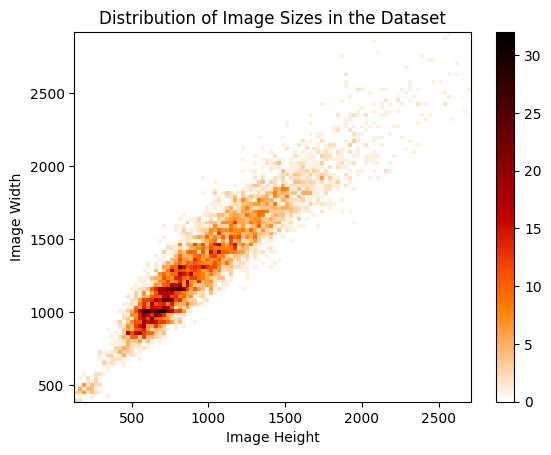

Average height and width of images in the total dataset are 1057.7853912524695 and 1417.6407725170839 respectively, with aspect ratio 0.7461589788887948


In [14]:
# plot the distribution of the images in the dataset using hist2d, one hist2d for all the data but the points have different colors per key
plt.hist2d(hist_data['x'], hist_data['y'], bins=(100, 100), cmap=plt.cm.gist_heat_r)
plt.colorbar()
plt.title('Distribution of Image Sizes in the Dataset')
plt.xlabel('Image Height')
plt.ylabel('Image Width')
plt.show()

avg_total_height = (
    average_height_width_train['train']['normal']['height'] + 
    average_height_width_train['train']['pneumonia']['height'] + 
    average_height_width_train['test']['normal']['height'] + 
    average_height_width_train['test']['pneumonia']['height'] +
    average_height_width_train['val']['normal']['height'] + 
    average_height_width_train['val']['pneumonia']['height']
) / 6  
avg_total_width = (
    average_height_width_train['train']['normal']['width'] + 
    average_height_width_train['train']['pneumonia']['width'] + 
    average_height_width_train['test']['normal']['width'] + 
    average_height_width_train['test']['pneumonia']['width'] +
    average_height_width_train['val']['normal']['width'] + 
    average_height_width_train['val']['pneumonia']['width']
) / 6  

avg_aspect_ratio = avg_total_height / avg_total_width if avg_total_width != 0 else None 

print(f"Average height and width of images in the total dataset are {avg_total_height} and {avg_total_width} respectively, with aspect ratio {avg_aspect_ratio if avg_aspect_ratio is not None else 'undefined'}")

## Resizing and Saving Images

### Function: `resize_and_save_images`
This function resizes images from a specified input directory to a given output directory based on predefined average height and width dimensions:
- **Parameters**: Accepts paths for input and output directories, and optionally average dimensions. Default dimensions are derived from the dataset's computed averages.
- **Directory Creation**: Ensures the output directory exists; if not, it creates the directory.
- **Processing**: Iterates through each image in the input directory, resizes it to the specified dimensions, and saves it to the output directory. It also provides status updates on the number of images processed.
- **Console Management**: Clears the console after each image is processed to keep the output clean (specific to the OS).

### Usage
This script is applied to both 'NORMAL' and 'PNEUMONIA' image categories within the training dataset, ensuring all images are uniformly resized. This standardization is crucial for consistent input to machine learning models.

The function's output includes confirmation of the total number of images resized and saved, aiding in verification and debugging.


In [15]:
def resize_and_save_images(input_path, output_path, average_height=avg_total_height, average_width=avg_total_width):
    average_height = int(average_height)
    average_width = int(average_width)
    print(f"Resizing and saving images from {input_path} to {output_path} at {average_height}x{average_width}")
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    filelist = os.listdir(input_path)
    print(f"Found {len(filelist)} images in {input_path}")
    for filename in filelist:
        print(f"Processing {filename}... image {filelist.index(filename)+1} of {len(filelist)}")
        img_path = os.path.join(input_path, filename)
        with Image.open(img_path) as img:
            resized_img = img.resize((average_width, average_height))
            resized_img.save(os.path.join(output_path, filename))
        # clear console
        os.system('cls' if os.name == 'nt' else 'clear')
    print(f"Processed {len(filelist)} images.")
    

resize_and_save_images(dir_paths['train_normal'], os.path.join(temp_dir_base, 'train/normal'))
resize_and_save_images(dir_paths['train_pneumonia'], os.path.join(temp_dir_base, 'train/pneumonia'))
resize_and_save_images(dir_paths['test_normal'], os.path.join(temp_dir_base, 'test/normal'))
resize_and_save_images(dir_paths['test_pneumonia'], os.path.join(temp_dir_base, 'test/pneumonia'))
resize_and_save_images(dir_paths['val_normal'], os.path.join(temp_dir_base, 'val/normal'))
resize_and_save_images(dir_paths['val_pneumonia'], os.path.join(temp_dir_base, 'val/pneumonia'))


print("✅ Images resized and saved successfully")

Resizing and saving images from ./data\train\NORMAL to c:\Users\i\Documents\project\t-dev-810-par_14\data/local\train/normal at 1057x1417
Found 1341 images in ./data\train\NORMAL
Processing IM-0115-0001.jpeg... image 1 of 1341
Processing IM-0117-0001.jpeg... image 2 of 1341
Processing IM-0119-0001.jpeg... image 3 of 1341
Processing IM-0122-0001.jpeg... image 4 of 1341
Processing IM-0125-0001.jpeg... image 5 of 1341
Processing IM-0127-0001.jpeg... image 6 of 1341
Processing IM-0128-0001.jpeg... image 7 of 1341
Processing IM-0129-0001.jpeg... image 8 of 1341
Processing IM-0131-0001.jpeg... image 9 of 1341
Processing IM-0133-0001.jpeg... image 10 of 1341
Processing IM-0135-0001.jpeg... image 11 of 1341
Processing IM-0137-0001.jpeg... image 12 of 1341
Processing IM-0140-0001.jpeg... image 13 of 1341
Processing IM-0141-0001.jpeg... image 14 of 1341
Processing IM-0143-0001.jpeg... image 15 of 1341
Processing IM-0145-0001.jpeg... image 16 of 1341
Processing IM-0147-0001.jpeg... image 17 of 13

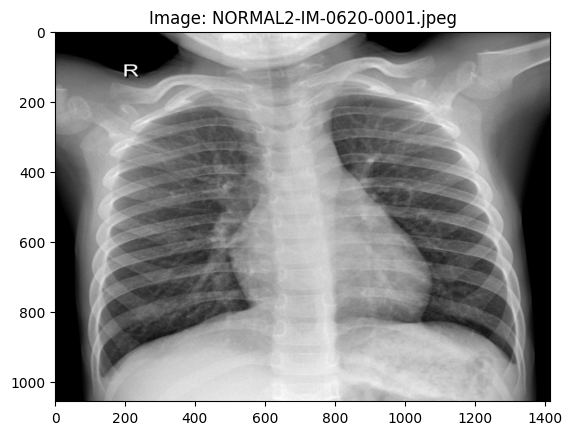

Shape of image from c:\Users\i\Documents\project\t-dev-810-par_14\data/local\train/normal\NORMAL2-IM-0620-0001.jpeg is (1057, 1417, 3)


In [16]:
# pick random image from the tmp directory and plot it
random_dir = random.choice(['train/normal', 'train/pneumonia', 'test/normal', 'test/pneumonia', 'val/normal', 'val/pneumonia'])
filelist = os.listdir(os.path.join(temp_dir_base, random_dir))
filelist_random = random.choice(filelist)
plotted_image = os.path.join(temp_dir_base, random_dir, filelist_random)
plot_image(plotted_image, filelist_random)

In [27]:
avg_total_height, avg_total_width = 150, 150
def load_images_from_folder(folder, label, target_size=(avg_total_height, avg_total_width)):
    target_size= (round(target_size[0]), round(target_size[1]))
    print(f"Loading images from {folder} with label {label}")
    files = os.listdir(folder)
    for idx, filename in enumerate(files):
        print(f"Processing image {filename} index {idx + 1} of {len(files)}")
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size) 
            yield img.flatten(), label

def data_from_generator(generator):
    images, labels = [], []
    for img, lbl in generator:
        images.append(img)
        labels.append(lbl)
    return np.array(images), np.array(labels)

def process_dataset(base_dir, sets, categories):
    data = {}
    for set_name in sets:
        images, labels = [], []
        for category in categories:
            folder_path = os.path.join(base_dir, set_name, category)
            gen = load_images_from_folder(folder_path, category)
            imgs, lbls = data_from_generator(gen)
            images.extend(imgs)
            labels.extend(lbls)
        data[set_name] = (np.array(images), np.array(labels))
    
    return data

categories = ['normal', 'pneumonia']
sets = ['train', 'val', 'test']

data = process_dataset(base_dir, sets, categories)

print("✅ Data is successfully loaded and preprocessed")

Loading images from ./data\train\normal with label normal
Processing image IM-0115-0001.jpeg index 1 of 1341
Processing image IM-0117-0001.jpeg index 2 of 1341
Processing image IM-0119-0001.jpeg index 3 of 1341
Processing image IM-0122-0001.jpeg index 4 of 1341
Processing image IM-0125-0001.jpeg index 5 of 1341
Processing image IM-0127-0001.jpeg index 6 of 1341
Processing image IM-0128-0001.jpeg index 7 of 1341
Processing image IM-0129-0001.jpeg index 8 of 1341
Processing image IM-0131-0001.jpeg index 9 of 1341
Processing image IM-0133-0001.jpeg index 10 of 1341
Processing image IM-0135-0001.jpeg index 11 of 1341
Processing image IM-0137-0001.jpeg index 12 of 1341
Processing image IM-0140-0001.jpeg index 13 of 1341
Processing image IM-0141-0001.jpeg index 14 of 1341
Processing image IM-0143-0001.jpeg index 15 of 1341
Processing image IM-0145-0001.jpeg index 16 of 1341
Processing image IM-0147-0001.jpeg index 17 of 1341
Processing image IM-0149-0001.jpeg index 18 of 1341
Processing imag

In [28]:
X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']


print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print("✅ Data is successfully broken down into training, validation, and testing sets")

Training data shape: (5216, 22500), Labels shape: (5216,)
✅ Data is successfully broken down into training, validation, and testing sets


In [30]:
# Decision Tree Classifier
decision_clf = DecisionTreeClassifier(max_depth=5, random_state=42)  
decision_clf.fit(X_train, y_train)

# save the model
if not os.path.exists('./models'):
    os.makedirs('./models')
    
joblib.dump(decision_clf, './models/decision_classifier.pkl')
print("✅ Model saved successfully")

✅ Model saved successfully


In [38]:
kn_clf = KNeighborsClassifier(n_neighbors=3)
kn_clf.fit(X_train, y_train)

# save the model
if not os.path.exists('./models'):
    os.makedirs('./models')

joblib.dump(kn_clf, './models/kn_classifier.pkl')
print("✅ Model saved successfully")


✅ Model saved successfully


In [39]:
available_models = [
    {
        'name': 'Decision Tree Classifier',
        'model': 'decision_clf',
        'path': './models/decision_classifier.pkl',
        
    },
    {
        'name': 'K-Nearest Neighbors Classifier',
        'model': 'kn_clf',
        'path': './models/kn_classifier.pkl'
    },
]

def load_model(model_object) :
    if not os.path.exists(model_object['path']):
        raise FileNotFoundError("Model file not found")
    # if variable decision_clf is not defined then load the model if it is defined then print model is already loaded
    if model_object['model'] not in locals():
        model = joblib.load(model_object['path'])
        print("✅ Model loaded successfully")
    else:
        print("✅ Model is already loaded")
    print(f"✅ Model {model_object['name']} has been loaded successfully")
    return model

current_model = available_models[1]

clf = load_model(current_model)

# Validate model
y_pred_val = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Validation Report:", classification_report(y_val, y_pred_val))

# Test model
y_pred_test = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test Report:", classification_report(y_test, y_pred_test))

✅ Model loaded successfully
✅ Model K-Nearest Neighbors Classifier has been loaded successfully
Validation Accuracy: 0.5625
Validation Report:               precision    recall  f1-score   support

      normal       1.00      0.12      0.22         8
   pneumonia       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

Test Accuracy: 0.7467948717948718
Test Report:               precision    recall  f1-score   support

      normal       0.95      0.34      0.50       234
   pneumonia       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



✅ Model evaluation Decision Classifier Tree function is successfully defined
Validation Accuracy: 0.8125
Validation Report:
              precision    recall  f1-score   support

      normal       1.00      0.62      0.77         8
   pneumonia       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16

Test Accuracy: 0.6923076923076923
Test Report:
              precision    recall  f1-score   support

      normal       0.74      0.28      0.40       234
   pneumonia       0.68      0.94      0.79       390

    accuracy                           0.69       624
   macro avg       0.71      0.61      0.60       624
weighted avg       0.70      0.69      0.65       624



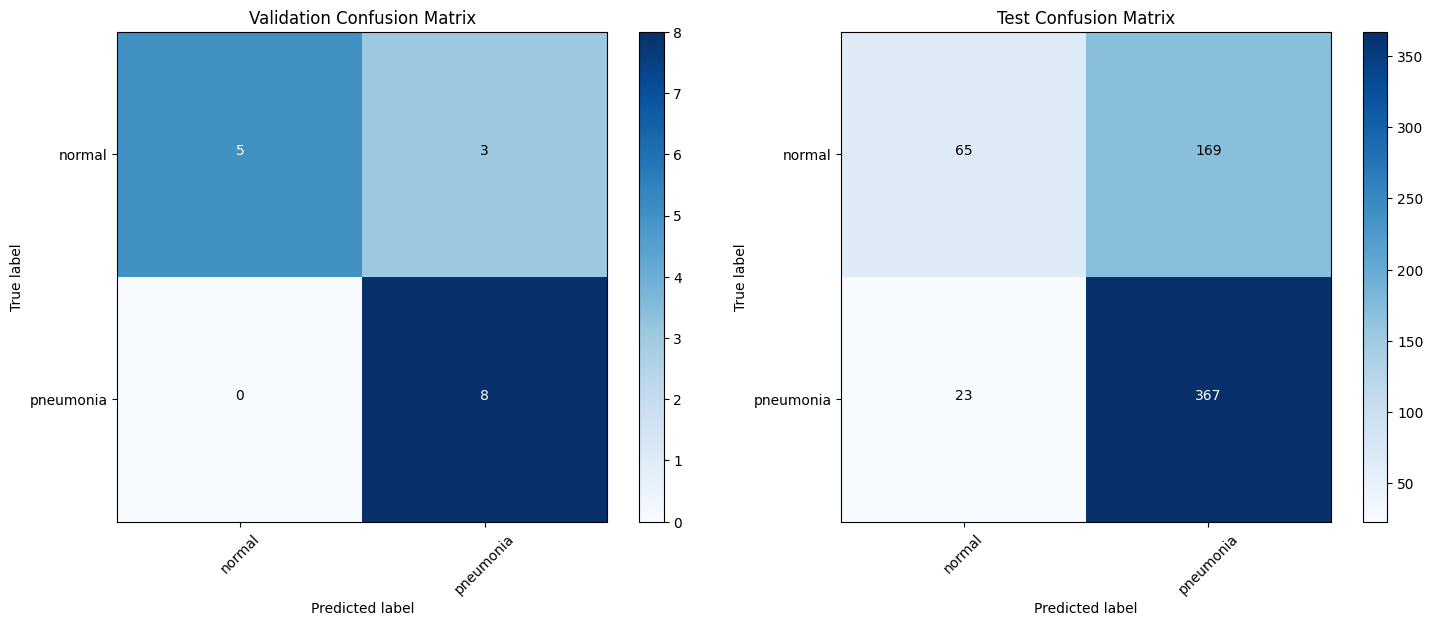

✅ Model evaluation K-Nearest Neighbors Classifier function is successfully defined
Validation Accuracy: 0.5625
Validation Report:
              precision    recall  f1-score   support

      normal       1.00      0.12      0.22         8
   pneumonia       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16

Test Accuracy: 0.7467948717948718
Test Report:
              precision    recall  f1-score   support

      normal       0.95      0.34      0.50       234
   pneumonia       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



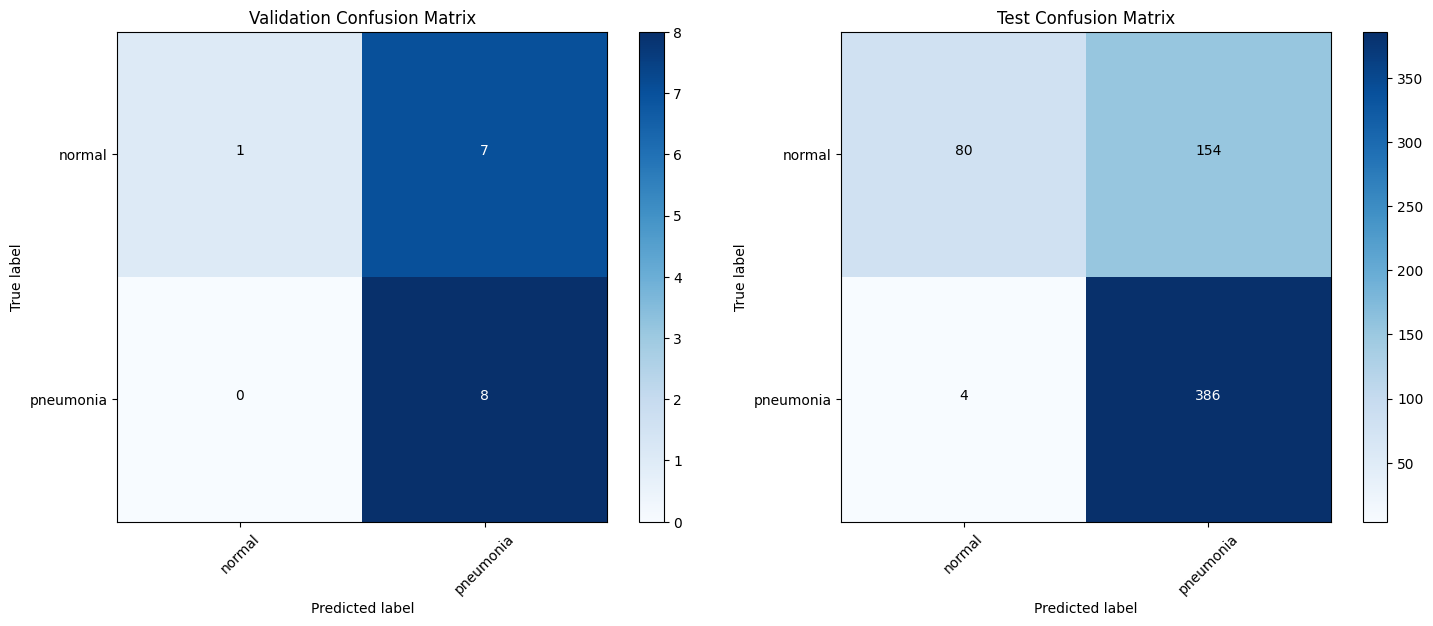

In [49]:

def plot_confusion_matrices(y_val_true, y_val_pred, y_test_true, y_test_pred, title1='Validation Confusion Matrix', title2='Test Confusion Matrix'):
    """
    Plots validation and test confusion matrices side by side.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    percentage_val = accuracy_score(y_val_true, y_val_pred, normalize=True) * 100
    percentage_test = accuracy_score(y_test_true, y_test_pred, normalize=True) * 100
    title1 += f" (Accuracy: {percentage_val:.2f}%)"
    title2 += f" (Accuracy: {percentage_test:.2f}%)"
    
    # List of true and predicted values
    true_values = [y_val_true, y_test_true]
    pred_values = [y_val_pred, y_test_pred]
    titles = [title1, title2]

    # Loop through the axes and true/pred values
    for ax, y_true, y_pred, title in zip(axes, true_values, pred_values, titles):
        cm = confusion_matrix(y_true, y_pred)
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set_title(title)
        tick_marks = np.arange(len(np.unique(y_true)))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(np.unique(y_true), rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(np.unique(y_true))

        # Label the plot
        thresh = cm.max() / 2.
        for i, j in np.ndindex(cm.shape):
            ax.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_val, y_val, X_test, y_test):
    """
    Evaluates the model on validation and test datasets, prints accuracy and classification report,
    and plots inline confusion matrices.
    """
    # Validation
    y_pred_val = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
    print("Validation Report:")
    print(classification_report(y_val, y_pred_val))

    # Testing
    y_pred_test = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Test Report:")
    print(classification_report(y_test, y_pred_test))

    plot_confusion_matrices(y_val, y_pred_val, y_test, y_pred_test)

# Assuming clf, X_val, y_val, X_test, and y_test are defined as per your code setup.
print("✅ Model evaluation Decision Classifier Tree function is successfully defined")
evaluate_model(decision_clf, X_val, y_val, X_test, y_test)

#KN evaluation
print("✅ Model evaluation K-Nearest Neighbors Classifier function is successfully defined")
evaluate_model(kn_clf, X_val, y_val, X_test, y_test)


In [1]:
# clean up the temporary directories
# delete all the files in the temp_dir_base
if os.name == 'nt': # windows
    os.system(f"del /f /q {temp_dir_base}\\*")
else: # linux
    os.system(f"rm -rf {temp_dir_base}/*")

print("Temporary directory deleted successfully")



NameError: name 'os' is not defined